# Main processing and calculations
This notebook merges all new sample data together for Kilauea Pre-Post Caldera project (Ulu, 1974 SWRZ, 2020, June 2024 SWRZ and December 2024) and performs final calculations prior to plotting. 
 NOTE that at this point we have already merged Raman, SEM-EDS, SEM-EBSD and any other matrix glass data for individual samples (each in its own subdirectory of the Data_processing_notebooks folder).
The steps are as follows:
- 1. Import dependencies and install packages
- 2. merge all sample datasets
- 3. calculate SO2 mol% from Raman ratios
- 4. Calculate T from olivine only thermometer using SEM-EDS on host olivines
- 5. Calculate XH2O iteratively 
- 6. Calculate final P and D and uncertainty via Monte Carlo simulations
- 7. Exports final dataset to excel for plotting in a separate notebook

## 1. Import packages and setup folders and paths

### Install packages if not installed

In [1]:
#%pip install --upgrade DiadFit
#%pip install Thermobar


### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
import os
import pickle

### Setup folders and data paths

In [3]:
# This is to make sure the code runs regardless of operating system
if os.name=='posix':
    slash='/'
else:
    slash='\\'

# Set master folder
MasterFolder=os.path.dirname(os.getcwd())

# #Folder to save figures

figpath=MasterFolder +slash+"Data_processing_notebooks"+slash+'Processing Figs'
if not os.path.exists(figpath):
    os.mkdir(figpath)

# Create folder to save full datasets

compilation_folder=MasterFolder +slash+"Data_processing_notebooks"+slash+'Notebook_Compiled_data'
if not os.path.exists(compilation_folder):
    os.mkdir(compilation_folder)

## 2. Merge all the datasets together

### Import the Fully merged SWRZ data


In [4]:
KL_SWRZ=pd.read_excel(MasterFolder +slash+"Data_processing_notebooks"+slash+'Data_processing_SWRZ'+slash+'Notebook_Compiled_data'+slash+'SWRZ_Final_data_wEBSD.xlsx')

KL_SWRZ =KL_SWRZ.loc[:, ~KL_SWRZ.columns.str.contains('Unnamed')].copy()

KL_SWRZ.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,GB Length/Sqrt Size,Total GB length,Tilt length,Twist length,Perc Tilt,Perc Twist,Perc unclassified,Divangle,Deformed,Day_EBSDdata
0,KL0919-010-A,0.119384,0.004053,0.001334,0.003827,103.051548,0.003366,0.001044,0.003205,11.971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KL0919-010-B,0.105191,0.008116,0.007167,0.003809,103.015728,0.018087,0.001047,0.018082,11.965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KL0919-010-C-meltfilm,0.090413,0.004864,0.003034,0.003801,102.978432,0.007658,0.001050,0.007596,11.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KL0919-011-A,0.141729,0.004629,0.002532,0.003876,103.107941,0.006389,0.001061,0.006309,11.956,...,0.979728,56.64658,50.451855,5.15671,89.064256,9.103303,1.83244,NaN,Uncertain,1.0
4,KL0919-011-C,0.156472,0.004005,0.000818,0.003921,103.145147,0.002064,0.001068,0.001769,11.954,...,0.979728,56.64658,50.451855,5.15671,89.064256,9.103303,1.83244,NaN,Uncertain,1.0


### Import the December 2024 Data
- Remember to update once I have EDS and EBSD

In [5]:
KD24=pd.read_excel(MasterFolder +slash+"Data_processing_notebooks"+slash+'Data_processing_KS24-628'+slash+'Notebook_Compiled_data'+slash+'KD24_Raman_EDS_Gl_Merged.xlsx')
KD24 =KD24.loc[:, ~KD24.columns.str.contains('Unnamed')]

KD24.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Ni_STD_Gl,Cu_STD_Gl,Zn_STD_Gl,Rb_STD_Gl,Sr_STD_Gl,Y_STD_Gl,Zr_STD_Gl,Nb_STD_Gl,Ba_STD_Gl,averaged?_Gl
0,FG04-A1-4-end_r5,0.691934,0.003428,0.002393,0.002391,104.330131,0.004693,0.000555,0.004667,6.016000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FG04-A1-4-end-rep3,0.688868,0.004143,0.003362,0.002390,104.324111,0.006603,0.001066,0.006526,6.065750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FG04-A1-4-start_r1,0.688678,0.004276,0.003481,0.002390,104.323735,0.006836,0.000534,0.006827,6.001667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KD24_c001_a1_FIA_r1,0.086661,0.007504,0.006332,0.003802,102.968963,0.015979,0.000515,0.016004,9.912000,...,2.986079,5.678908,11.528949,0.957427,8.020806,0.816497,2.986079,0.5,3.593976,Yes
4,KD24_c001_a1_FIB,0.062668,0.006605,0.005391,0.003817,102.908411,0.013605,0.000513,0.013625,9.855000,...,2.986079,5.678908,11.528949,0.957427,8.020806,0.816497,2.986079,0.5,3.593976,Yes


### Import the 2020 Data
- Remember to update once I have EDS and EBSD

In [6]:
K20=pd.read_excel(MasterFolder +slash+"Data_processing_notebooks"+slash+'Data_processing_KS20-527'+slash+'Notebook_Compiled_data'+slash+'K20_Raman_EDS_Gl_Merged.xlsx')
K20 =K20.loc[:, ~K20.columns.str.contains('Unnamed')]

K20.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,MgO_STD_Gl,CaO_STD_Gl,Na2O_STD_Gl,K2O_STD_Gl,P2O5_STD_Gl,SO3_STD_Gl,Cl_STD_Gl,F_STD_Gl,Total_STD_Gl,averaged?_Gl
0,FG04-A1-4-100X-start_r4,0.696462,0.006099,0.005609,0.002392,104.338995,0.010976,0.001514,0.010895,5.984000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FG04-A1-4-50X-end_r7,0.688075,0.004044,0.003235,0.002390,104.322548,0.006358,0.001614,0.006150,6.040000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FG04-A1-4-50X-start_r1,0.690809,0.003109,0.001986,0.002391,104.327891,0.003898,0.001528,0.003593,5.979667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FG04-A1-4-end_r4,0.694369,0.005155,0.004541,0.002392,104.334870,0.008904,0.000712,0.008893,6.004000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FG04-A1-4-start_r1,0.693323,0.004397,0.003690,0.002391,104.332851,0.007232,0.000650,0.007218,6.092667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Import the old Keanakakoi, uekahuna and littoral cone data
- I don't have EBSD or glasses on these

In [7]:
K21_L84_UW=pd.read_excel(MasterFolder +slash+"Data_processing_notebooks"+slash+'Data_processing_Keana_Uwe_Litt'
                         +slash+'Notebook_Compiled_data'+slash+'K21_L84_UW_mergedEPMA.xlsx')
K21_L84_UW =K21_L84_UW.loc[:, ~K21_L84_UW.columns.str.contains('Unnamed')]

K21_L84_UW.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,D.L_Ol,Ca(D.L.)_Ol,Ti(D.L.)_Ol,Si(D.L.)_Ol,Al(D.L.)_Ol,Mg(D.L.)_Ol,Fe(D.L.)_Ol,Mn(D.L.)_Ol,Ni(D.L.)_Ol,Cr(D.L.)_Ol
0,FO1_MI1-Oct2822postpin,0.093418,0.004147,0.001605,0.003803,102.986018,0.004050,0.000577,0.004014,11.974000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K21-51rep1,0.136553,0.005473,0.003755,0.003862,103.094878,0.009476,0.000554,0.009478,12.100333,...,NaN,69.0,95.0,115.0,43.0,48.0,95.0,83.0,54.0,63.0
2,K21-53-FI#4,0.017623,0.007732,0.006662,0.003925,102.794730,0.016813,0.000545,0.016841,19.972000,...,NaN,71.0,99.0,115.0,45.0,45.0,95.0,85.0,54.0,61.0
3,K21-54-FI#2,0.102444,0.004640,0.002654,0.003807,103.008795,0.006697,0.000553,0.006689,11.984000,...,NaN,70.0,99.0,115.0,43.0,45.0,96.0,80.0,52.0,59.0
4,K21-54-FI#4,0.068174,0.027324,0.027057,0.003811,102.922308,0.068284,0.000559,0.068433,11.973000,...,NaN,71.0,98.0,117.0,44.0,45.0,91.0,82.0,51.0,61.0


### Import the other new Ulu Data
- Remember to update once I have it


### Now let's merge all the datasets together
- Eventually, at this point this means all the complete Raman+EDS+EBSD datasets for each eruption
- Add other Ulu once I analyze
- Filter out the standards and re-export

##### I will have to make sure merging is smooth with the data that has epma can't decide if _EPMA is better or not

In [8]:
## Combine samples, export (includes the standards)
combo_df=pd.concat([KL_SWRZ,KD24,K20,K21_L84_UW],axis=0).dropna(axis=0,how='all').dropna(axis=1,how='all')

combo_df.to_excel(compilation_folder+slash+'Samples_combined_with_Standards_NoPDcalcs.xlsx')

## Filter standards and export both
standards=combo_df[combo_df['filename'].str.contains('FG|Fo|FO')].reset_index(drop=True)
combo_df=combo_df[~combo_df['filename'].str.contains('FG|Fo|FO')].reset_index(drop=True)

combo_df.to_excel(compilation_folder+slash+'Samples_combined_No_Standards_NoPDcalcs.xlsx')
standards.to_excel(compilation_folder+slash+'Standards_only_NoPDcalcs.xlsx')

combo_df.head()

/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_3660/2408935340.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combo_df=pd.concat([KL_SWRZ,KD24,K20,K21_L84_UW],axis=0).dropna(axis=0,how='all').dropna(axis=1,how='all')


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Cr(Error%)_Ol,Ca(D.L.)_Ol,Ti(D.L.)_Ol,Si(D.L.)_Ol,Al(D.L.)_Ol,Mg(D.L.)_Ol,Fe(D.L.)_Ol,Mn(D.L.)_Ol,Ni(D.L.)_Ol,Cr(D.L.)_Ol
0,KL0919-010-A,0.119384,0.004053,0.001334,0.003827,103.051548,0.003366,0.001044,0.003205,11.971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KL0919-010-B,0.105191,0.008116,0.007167,0.003809,103.015728,0.018087,0.001047,0.018082,11.965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KL0919-010-C-meltfilm,0.090413,0.004864,0.003034,0.003801,102.978432,0.007658,0.001050,0.007596,11.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KL0919-011-A,0.141729,0.004629,0.002532,0.003876,103.107941,0.006389,0.001061,0.006309,11.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KL0919-011-C,0.156472,0.004005,0.000818,0.003921,103.145147,0.002064,0.001068,0.001769,11.954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# ## Combine samples, export (includes the standards)

# K21_L84_UW.to_excel(compilation_folder+slash+'K21_L84_UW_Samples_with_Standards_NoPDcalcs.xlsx')

# ## Filter standards and export both
# standards=K21_L84_UW[K21_L84_UW['filename'].str.contains('FG|Fo|FO')].reset_index(drop=True)
# K21_L84_UW=K21_L84_UW[~K21_L84_UW['filename'].str.contains('FG|Fo|FO')].reset_index(drop=True)

# K21_L84_UW.to_excel(compilation_folder+slash+'K21_L84_UW_Samples_No_Standards_NoPDcalcs.xlsx')
# standards.to_excel(compilation_folder+slash+'K21_L84_UW_Standards_only_NoPDcalcs.xlsx')

# K21_L84_UW.head()

## 3. Calculate SO2 mol % from Raman

In [10]:
# combo_df['SO2 mol%']=pf.calculate_mole_fraction_2comp(peak_area_a=combo_df['Peak_Area_SO2'], peak_area_b=combo_df['Diad1_Voigt_Area']+combo_df['Diad2_Voigt_Area'],
#                                   cross_section_a=5.3, cross_section_b=1.4+0.89, instrument_eff_a=1, instrument_eff_b=1)['% A']
combo_df['SO2 mol%']=pf.calculate_mole_fraction_2comp(peak_area_a=combo_df['Peak_Area_SO2'], peak_area_b=combo_df['Diad1_Voigt_Area']+combo_df['Diad2_Voigt_Area'],
                                  cross_section_a=5.791, cross_section_b=1.44+0.994, instrument_eff_a=1, instrument_eff_b=1)['% A']

# # 515 and 532 nm
# # 0.985	0.994
# # 1.428	1.440
# #combo_df['Fo']=(combo_df['MgO']/40.3044)/((combo_df['MgO']/40.3044)+(combo_df['FeOt']/71.844))
# plt.scatter(combo_df['SO2 mol%_new'],100*abs((combo_df['SO2 mol%']-combo_df['SO2 mol%_new']))/combo_df['SO2 mol%_new'])
# plt.xlabel ('SO2 mol% using new cross sections')
# plt.ylabel(r'$\frac{(SO2\ mol\%\_burke\_values - SO2\ mol\%\_new)}{SO2\ mol\%}$')

## 4. Calculate the Temperature from olivine only thermometer
- This uses the T vs Fo relationship from DeVitre and Wieser (2024) GPL for Kilauea

### A. Load the Temp vs Fo correction relationship for Kilauea

In [11]:
with open(os.getcwd()+slash+'T and XH2O pickles'+slash+'TempFoModel.pkl', 'rb') as f:
    Pf_TempFo = pickle.load(f)

### B. Calculate Temperature from Fo and plot the distribution
- When no EDS data is available we use the mean T from the dataset (once I have other samples I can maybe do a mean per sample)
- We establish the error on T (+- 50K for now)

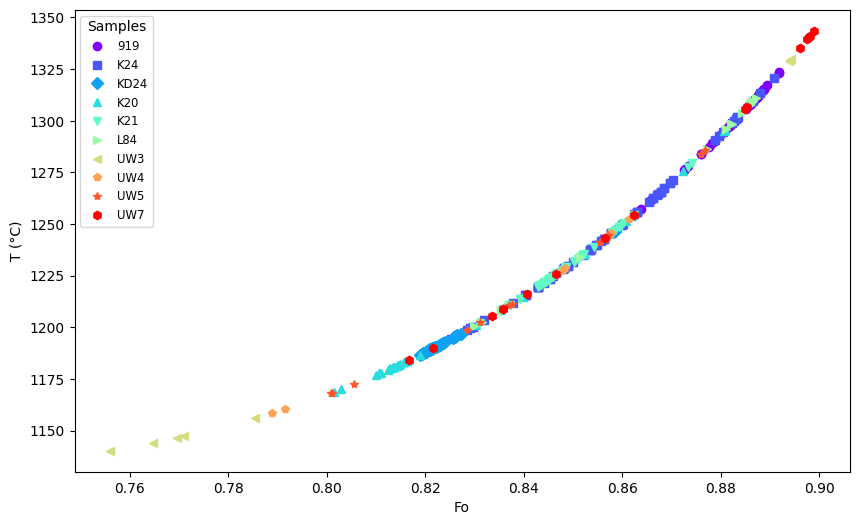

In [12]:
combo_df['Temp_from_Fo_all']=Pf_TempFo(combo_df['Fo_Ol'])
MeanT=np.nanmean(combo_df['Temp_from_Fo_all'])
combo_df['Temp_from_Fo_all'] = combo_df['Temp_from_Fo_all'].fillna(MeanT)

# Create Temp error column, we use 50K +- for now.
combo_df['Temp_error'] = np.where(combo_df['Temp_from_Fo_all'] == MeanT, 50, 50)

####### Now let's plot the Temp vs Fo to visualize the distribution
unique_samples = combo_df['Sample'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_samples)))
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'H', '+', 'x', 'X']  # List of markers

if len(unique_samples) > len(markers):
    print("Warning: More samples than available marker types; some markers will repeat.")

plt.figure(figsize=(10, 6))

for sample, color, marker in zip(unique_samples, colors, markers * (len(unique_samples) // len(markers) + 1)):
    sample_data = combo_df[combo_df['Sample'] == sample]
    plt.plot(
        sample_data['Fo_Ol'], 
        sample_data['Temp_from_Fo_all'], 
        linestyle='none', 
        marker=marker, 
        label=sample, 
        color=color
    )

plt.xlabel('Fo')
plt.ylabel('T (°C)')

plt.legend(title="Samples", loc="best", fontsize='small')
plt.savefig(figpath+slash+'Temp_vs_Fo_plot.pdf')
plt.show()

## 5. Calculate the XH2O in the fluid inclusions
- This uses the relationships from DeVitre and Wieser (2024) GPL
- First we import the pickles (min, average, max - see paper for details)
- Then we calculate a first approximation of pressure using pure CO2 EOS, and calculate a first approximation of XH2O from this pressure
- After that we recalculate the pressure using mixed CO2-H2O EOS from Duan and Zhang 2006
- We recalculate XH2O from this new pressure
- We recalculate pressure and XH2O one more time to ensure it has not varied

### A. First, import the pickles (polynomial relationships)

In [13]:
pf_files = ["PXH2O_min.pkl", "PXH2O_max.pkl", "PXH2O_av.pkl"]
Pf_functions = {}

for file_name, label in zip(pf_files, ["Pf_min", "Pf_max", "Pf_av"]):
    with open(os.path.join(os.getcwd(), "T and XH2O pickles", file_name), 'rb') as f:
        Pf_functions[label] = pickle.load(f)

Pf_min = Pf_functions["Pf_min"]
Pf_max = Pf_functions["Pf_max"]
Pf_av = Pf_functions["Pf_av"]

# And its defined as XH2O_av=1-Pf_med(P_SW96['P_MPa'])

### B. Calculate the first approximation XH2O

#### First, calculate approximated pressure with pure CO2 EOS

In [14]:
combo_df['P_kbar_pureCO2_firstapprox'] =pf.calculate_P_for_rho_T(CO2_dens_gcm3=combo_df['Density g/cm3'],
                                                                        T_K=combo_df['Temp_from_Fo_all'] + 273.15,
                                                                        EOS='SW96')['P_kbar']
combo_df.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Al(D.L.)_Ol,Mg(D.L.)_Ol,Fe(D.L.)_Ol,Mn(D.L.)_Ol,Ni(D.L.)_Ol,Cr(D.L.)_Ol,SO2 mol%,Temp_from_Fo_all,Temp_error,P_kbar_pureCO2_firstapprox
0,KL0919-010-A,0.119384,0.004053,0.001334,0.003827,103.051548,0.003366,0.001044,0.003205,11.971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1311.014317,50,0.389537
1,KL0919-010-B,0.105191,0.008116,0.007167,0.003809,103.015728,0.018087,0.001047,0.018082,11.965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1311.014317,50,0.339539
2,KL0919-010-C-meltfilm,0.090413,0.004864,0.003034,0.003801,102.978432,0.007658,0.001050,0.007596,11.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1311.014317,50,0.288622
3,KL0919-011-A,0.141729,0.004629,0.002532,0.003876,103.107941,0.006389,0.001061,0.006309,11.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1315.580801,50,0.471972
4,KL0919-011-C,0.156472,0.004005,0.000818,0.003921,103.145147,0.002064,0.001068,0.001769,11.954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1315.580801,50,0.527202


#### Next, we calculate the XH2O first approximation

In [15]:
# Create function to calculate XH2O from pickles that were loaded,
# If XH2O is negative we assign 0 to it
def calculate_XH2O(P_kbar, Pf_func):
    XH2O = 1 - Pf_func(P_kbar * 100)
    XH2O[XH2O < 0] = 0
    return XH2O

combo_df['XH2O_av_firstapprox'] = calculate_XH2O(combo_df['P_kbar_pureCO2_firstapprox'], Pf_av)
combo_df['XH2O_min_firstapprox'] = calculate_XH2O(combo_df['P_kbar_pureCO2_firstapprox'], Pf_min)
combo_df['XH2O_max_firstapprox'] = calculate_XH2O(combo_df['P_kbar_pureCO2_firstapprox'], Pf_max)

### C. Now, we iterate calculations using mixed H2O-CO2 EOS of Duan and Zhang
- We do 3 iterations: this means P, XH2O; P2, XH2O2;P3, XH2O final

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,P_kbar_mixCO2_DZ06_no_Hloss_max_iteration2,XH2O_av_iteration2,XH2O_min_iteration2,XH2O_max_iteration2,P_kbar_mixCO2_DZ06_no_Hloss_av_iteration3,P_kbar_mixCO2_DZ06_no_Hloss_min_iteration3,P_kbar_mixCO2_DZ06_no_Hloss_max_iteration3,XH2O_av_iteration3_final,XH2O_min_iteration3_final,XH2O_max_iteration3_final
0,KL0919-010-A,0.119384,0.004053,0.001334,0.003827,103.051548,0.003366,0.001044,0.003205,11.971,...,0.435324,0.077840,0.038064,0.116583,0.419187,0.403058,0.436275,0.077798,0.038062,0.116321
1,KL0919-010-B,0.105191,0.008116,0.007167,0.003809,103.015728,0.018087,0.001047,0.018082,11.965,...,0.385581,0.088536,0.043628,0.132274,0.369529,0.353328,0.386896,0.088466,0.043624,0.131807
2,KL0919-010-C-meltfilm,0.090413,0.004864,0.003034,0.003801,102.978432,0.007658,0.001050,0.007596,11.966,...,0.334857,0.102269,0.050615,0.152631,0.318812,0.302532,0.336563,0.102163,0.050611,0.151868
3,KL0919-011-A,0.141729,0.004629,0.002532,0.003876,103.107941,0.006389,0.001061,0.006309,11.956,...,0.517902,0.065174,0.031243,0.098318,0.501296,0.485004,0.518385,0.065160,0.031242,0.098236
4,KL0919-011-C,0.156472,0.004005,0.000818,0.003921,103.145147,0.002064,0.001068,0.001769,11.954,...,0.573989,0.059469,0.028010,0.090308,0.556751,0.540025,0.574267,0.059462,0.028010,0.090276


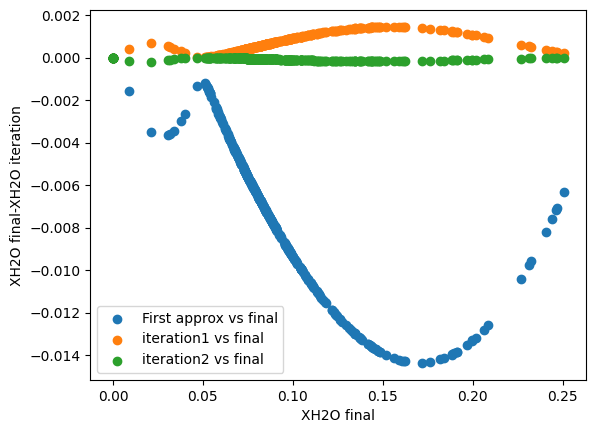

In [16]:
# First we make a function to calculate iterations of P using Duan and Zhang EOS
def calculate_entrapment_pressure(df, XH2O_col):
    return pf.calculate_entrapment_P_XH2O(
        XH2O=df[XH2O_col],
        CO2_dens_gcm3=df['Density g/cm3'],
        T_K=df['Temp_from_Fo_all'] + 273.15,
        T_K_ambient=37 + 273.15,
        fast_calcs=False,
        Hloss=True
    )['P_kbar_mixCO2_DZ06_no_Hloss']

# Then we iterate 3 times to get the final XH2O
for i in range(1, 4):
    if i == 1:
        suffix = '_firstapprox'
    else:
        suffix = f'_iteration{i - 1}'

    # Calculate pressures
    combo_df[f'P_kbar_mixCO2_DZ06_no_Hloss_av_iteration{i}'] = calculate_entrapment_pressure(combo_df, f'XH2O_av{suffix}')
    combo_df[f'P_kbar_mixCO2_DZ06_no_Hloss_min_iteration{i}'] = calculate_entrapment_pressure(combo_df, f'XH2O_min{suffix}')
    combo_df[f'P_kbar_mixCO2_DZ06_no_Hloss_max_iteration{i}'] = calculate_entrapment_pressure(combo_df, f'XH2O_max{suffix}')

    # Calculate XH2O
    combo_df[f'XH2O_av_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(combo_df[f'P_kbar_mixCO2_DZ06_no_Hloss_av_iteration{i}'], Pf_av)
    combo_df[f'XH2O_min_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(combo_df[f'P_kbar_mixCO2_DZ06_no_Hloss_min_iteration{i}'], Pf_min)
    combo_df[f'XH2O_max_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(combo_df[f'P_kbar_mixCO2_DZ06_no_Hloss_max_iteration{i}'], Pf_max)


plt.scatter(combo_df['XH2O_av_iteration3_final'],combo_df['XH2O_av_iteration3_final']-combo_df['XH2O_av_firstapprox'],label='First approx vs final')
plt.scatter(combo_df['XH2O_av_iteration3_final'],combo_df['XH2O_av_iteration3_final']-combo_df['XH2O_av_iteration1'],label='iteration1 vs final')
plt.scatter(combo_df['XH2O_av_iteration3_final'],combo_df['XH2O_av_iteration3_final']-combo_df['XH2O_av_iteration2'],label='iteration2 vs final')
plt.xlabel("XH2O final")
plt.ylabel("XH2O final-XH2O iteration")
plt.legend()
plt.savefig(figpath+slash+'XH2O_iteration.pdf')

combo_df.head()

## 6. Calculate final pressure and depth, propagate uncertainty and remerge

### A. Calculate final pressure and depth and propagate uncertainty using Monte Carlo simulation
- 500 duplicates
- Duan and Zhang (2006) EOS for mixed H2O-CO2 fluids
- CO2 density from Raman (error is sigma from DiadFit if not mean measurement, else it's standard deviation; absolute and normally distributed)
- XH2O is used from previous step (XH2O error as the half difference between min and max XH2O, absolute and normally distributed)
- Temperature from Forsterite content of host, or the mean of whole dataset when not available (Temperature error of +- 50K, absolute and normally distributed)
- Denlinger-lerner crustal model in DiadFit. 

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 200 regardless of what model you selected. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
We are using multiprocessing based on your selected EOS. You can override this by setting multiprocess=False in the function, but it might slow it down a lot
Number of processors:  8


,Filename,i,CO2_density_input,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,KL0919-010-A_2024-06-06_139281,0.0,0.119384,1.798498,0.421070,0.424479,0.422487,0.026950,0.025758,1.812119,...,1584.164317,50.0,0.119384,0.004053,None,0.0,denlinger_lerner,DZ06,0.077798,0.039130
1,KL0919-010-B_2024-06-06_139761,1.0,0.105191,1.593681,0.371181,0.375359,0.373816,0.037522,0.035719,1.610318,...,1584.164317,50.0,0.105191,0.008116,None,0.0,denlinger_lerner,DZ06,0.088466,0.044091
2,KL0919-010-C-meltfilm_2024-06-06_140092,2.0,0.090413,1.382270,0.320218,0.324010,0.322570,0.027710,0.026446,1.397745,...,1584.164317,50.0,0.090413,0.004864,None,0.0,denlinger_lerner,DZ06,0.102163,0.050629
3,KL0919-011-A_2024-06-06_141180,3.0,0.141729,2.132671,0.503563,0.507036,0.505061,0.029914,0.028342,2.146265,...,1588.730801,50.0,0.141729,0.004629,None,0.0,denlinger_lerner,DZ06,0.065160,0.033497
4,KL0919-011-C_2024-06-06_141923,4.0,0.156472,2.355421,0.559310,0.562758,0.560803,0.029983,0.029180,2.368772,...,1588.730801,50.0,0.156472,0.004005,None,0.0,denlinger_lerner,DZ06,0.059462,0.031133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,UW7-OX6-FI#2-12mW-R1_2022-11-08_50606,371.0,0.134985,2.020556,0.475735,0.477446,0.476922,0.023090,0.023318,2.027255,...,1578.825924,50.0,0.134985,0.002217,None,0.0,denlinger_lerner,DZ06,0.068803,0.035080
372,UW7-OX7-FI#1_2022-11-08_51777,372.0,0.171994,2.481695,0.591184,0.590753,0.589650,0.030938,0.029633,2.479631,...,1516.338771,50.0,0.171994,0.003587,None,0.0,denlinger_lerner,DZ06,0.057018,0.030187
373,UW7-OX8-FI#1_2022-11-08_52916,373.0,0.120475,1.706084,0.398497,0.398485,0.398104,0.026410,0.025409,1.705740,...,1481.912994,50.0,0.120475,0.003967,None,0.0,denlinger_lerner,DZ06,0.082338,0.041236
374,UW7-OX8-FI#2_2022-11-08_53279,374.0,0.126914,1.793828,0.419927,0.418397,0.417657,0.026425,0.027026,1.787287,...,1481.912994,50.0,0.126914,0.004174,None,0.0,denlinger_lerner,DZ06,0.078040,0.039251


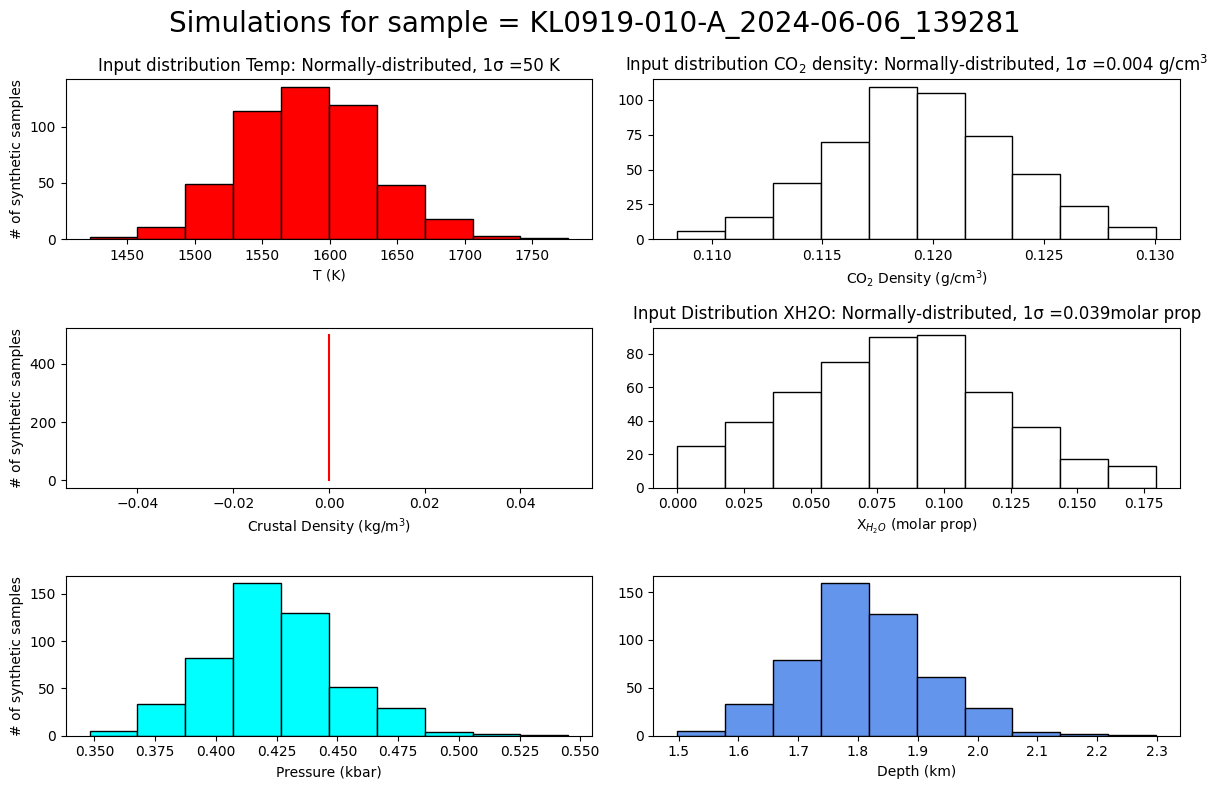

In [17]:
# ## Before doing this, to ensure proper merging we have to create a new column in combo_df
combo_df['MCSim_filename(_date_secsincemidnight)']=combo_df['filename']+"_"+combo_df['date_object'].astype('str')+"_"+combo_df['sec since midnight'].astype('str').str.split('.').str[0]

# ## We also create a new column with the CO2 density error, 
# ## if the measurement was averaged, the error is the standard deviation ('Density g/cm3_Raman_STD') 
# ## if it's a single measurement, it's the sigma from DiadFit ('σ Density g/cm3')

combo_df['error_CO2_dens_STDifmean_σifnot'] = combo_df.apply(
    lambda row: row['Density g/cm3_Raman_STD'] if row['averaged?'] == 'Yes' else row['σ Density g/cm3'],
    axis=1
)

## Now run the simulations
MC_Av_rho_T_df_B, MC_All_rho_T_df_B, fig=pf.propagate_FI_uncertainty(
T_K=combo_df['Temp_from_Fo_all']+273.15,
error_T_K=combo_df['Temp_error'], error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=combo_df['Density g/cm3'],error_CO2_dens=combo_df['error_CO2_dens_STDifmean_σifnot'], 
error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
XH2O=combo_df['XH2O_av_iteration3_final'], error_XH2O=pd.Series(0.5*np.abs(combo_df['XH2O_max_iteration3_final']-combo_df['XH2O_min_iteration3_final'])), error_type_XH2O='Abs', error_dist_XH2O='normal',
sample_ID=combo_df['MCSim_filename(_date_secsincemidnight)'],
model='denlinger_lerner',
N_dup=500, fig_i=0, plot_figure=True)


fig.savefig(figpath+slash+'MCsimulation.pdf')
MC_Av_rho_T_df_B

### B. Merge results back into the main dataframe

In [18]:
# First, we rename the Filename column from the simulations, to merge 
MC_Av_rho_T_df_B=MC_Av_rho_T_df_B.rename(columns={'Filename':'MCSim_filename(_date_secsincemidnight)'})

# Then we merge back in using the special filename column
combo_df_wcalcs = pd.merge(combo_df,MC_Av_rho_T_df_B, how='outer', on='MCSim_filename(_date_secsincemidnight)', suffixes=[None, 'MCSim'])
combo_df_wcalcs
# to make sure of duplicate columns can use this code: combo_df_wcalcs[combo_df_wcalcs.columns[combo_df_wcalcs.columns.str.contains('filename')]]

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,919_50_FIA,0.141984,0.008781,0.007880,0.003876,103.108584,0.019886,0.000992,0.019891,12.02700,...,1586.067191,50.0,0.141984,0.008781,None,0.0,denlinger_lerner,DZ06,0.065145,0.033490
1,919_50_FIB,0.151694,0.004892,0.002947,0.003905,103.133089,0.007437,0.000995,0.007381,12.02100,...,1586.067191,50.0,0.151694,0.004892,None,0.0,denlinger_lerner,DZ06,0.061202,0.031835
2,919_51_FIA,0.191270,0.004434,0.003749,0.002369,103.221905,0.009185,0.001005,0.009143,12.01800,...,1585.870579,50.0,0.191270,0.004434,None,0.0,denlinger_lerner,DZ06,0.051709,0.028335
3,919_52_FIA,0.153743,0.004916,0.002978,0.003912,103.138260,0.007515,0.001008,0.007458,12.00900,...,1581.879866,50.0,0.153743,0.004916,None,0.0,denlinger_lerner,DZ06,0.060602,0.031591
4,919_52_FIB,0.143131,0.005096,0.003305,0.003879,103.111478,0.008341,0.001011,0.008292,12.00600,...,1582.911649,50.0,0.143131,0.005096,None,0.0,denlinger_lerner,DZ06,0.064755,0.033323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,UW7-OX6-FI#2-12mW-R1,0.134985,0.003937,0.000779,0.003858,103.090919,0.001967,0.000614,0.001871,9.06175,...,1578.825924,50.0,0.134985,0.002217,None,0.0,denlinger_lerner,DZ06,0.068803,0.035080
372,UW7-OX7-FI#1,0.171994,0.003587,0.002689,0.002373,103.174533,0.006629,0.000615,0.006614,12.00500,...,1516.338771,50.0,0.171994,0.003587,None,0.0,denlinger_lerner,DZ06,0.057018,0.030187
373,UW7-OX8-FI#1,0.120475,0.003967,0.001040,0.003829,103.054301,0.002625,0.000615,0.002557,12.01200,...,1481.912994,50.0,0.120475,0.003967,None,0.0,denlinger_lerner,DZ06,0.082338,0.041236
374,UW7-OX8-FI#2,0.126914,0.004174,0.001635,0.003840,103.070551,0.004127,0.000616,0.004090,12.02500,...,1481.912994,50.0,0.126914,0.004174,None,0.0,denlinger_lerner,DZ06,0.078040,0.039251


## 7. Final data export for plotting

In [19]:
combo_df_wcalcs.to_excel(compilation_folder+slash+'FinalNewDataset.xlsx')